In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

correctant = 0

def best_number_pca():
    # Load data from the CSV file
    data = pd.read_csv('lbp_features_train.csv', header=None)
    train_features = data.iloc[:, 1:].values
    
    # Preprocess the features using StandardScaler
    sc = StandardScaler()
    sc.fit(train_features)
    X_train_std = sc.transform(train_features)

    # Instantiate PCA
    num_components = 10
    pca = PCA(n_components=num_components)

    # Determine transformed features
    X_train_pca = pca.fit_transform(X_train_std)

    # Determine explained variance using explained_variance_ration_ attribute
    exp_var_pca = pca.explained_variance_ratio_

    # Cumulative sum of eigenvalues; This will be used to create step plot for visualizing the variance explained by each principal component.
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    # Create the visualization plot
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()


def load_and_preprocess_data(file_path):
    # Load data from the CSV file
    data = pd.read_csv(file_path, header=None)
    labels = data.iloc[:, 0].values
    features = data.iloc[:, 1:].values

    # Preprocess the features using StandardScaler
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    '''# Initialize PCA object with desired number of components
    num_components = 8  # Set the desired number of components
    pca = PCA(n_components=num_components)

    # Fit PCA model to the scaled data
    pca.fit(features_scaled)

    #Transform the data using the fitted PCA model
    features_scaled = pca.transform(features_scaled)'''
    
    # Encode categorical labels into numerical form
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    
    # Convert features and labels to torch tensors
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    labels_tensor = torch.tensor(labels_encoded, dtype=torch.long)
    
    return features_tensor, labels_tensor#, scaler, pca

In [2]:
def train_model(model, train_features, train_labels, batch_size):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    # ensure model is in training mode
    model.train()

    for i in range(0, len(train_features), batch_size):
        batch_features = train_features[i:i + batch_size].to(device)
        batch_labels = train_labels[i:i + batch_size].to(device)
        optimizer.zero_grad()

        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # keep track of loss value
        losses.append(loss.data.cpu().numpy())
            
    return losses


def evaluate_model(model, test_features, test_labels):

    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
    global correctant

    with torch.no_grad():
        test_features = test_features.to(device)
        test_labels = test_labels.to(device)
        outputs = model(test_features)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(test_labels.tolist()) 
        y_pred.extend(predicted.tolist())

        if correctant < accuracy_score(y_true, y_pred):
            torch.save(model.state_dict(), "MLP_state_dict.pth")
            correctant = accuracy_score(y_true, y_pred)
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

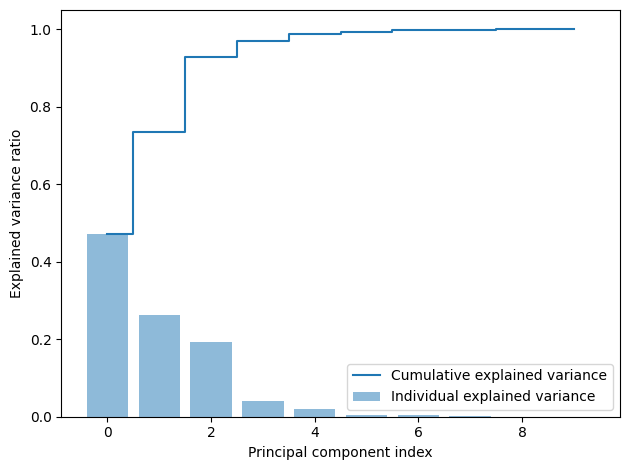

In [5]:
best_number_pca()

In [6]:
train_features, train_labels  = load_and_preprocess_data('lbp_features_train.csv')#, scaler_train, train_pca

In [7]:
test_features, test_labels = load_and_preprocess_data('lbp_features_test.csv')#, scaler_test, test_pca

In [8]:
# Define the MLP model
input_size = train_features.shape[1]

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = MLP(input_size)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)

Training loss = 0.470865 Test accuracy = 0.865000: 100%|██████████| 500/500 [01:25<00:00,  5.83it/s]


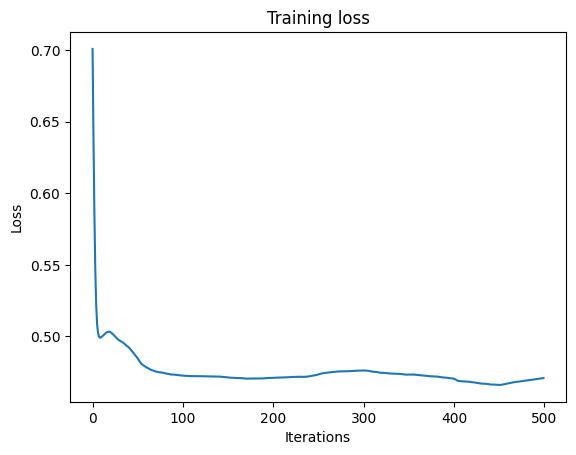

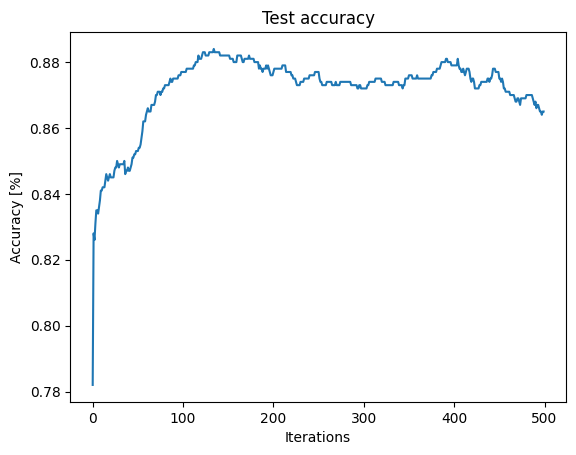

In [9]:
from tqdm import tqdm, trange
import numpy as np

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Train the MLP model
num_epochs = 500
batch_size = 128

running_loss = []
running_test_acc = []
t = trange(num_epochs, desc="Training loss", leave=True)

for epoch in t:
        loss_epoch = train_model(model, train_features, train_labels, batch_size)
        test_acc = evaluate_model(model, test_features, test_labels)
        t.set_description("Training loss = %f Test accuracy = %f" % (np.mean(loss_epoch), test_acc))
        t.refresh() # to show immediately the update           
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)


loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")